# SpaceNet8 Inference

2. foundation

## overview
- `data_prep` までは公開ベースラインと同じ
- 推論部分
- open baseline と同じ出力をする

1. metrics
2. threshold distribution
3. optimize threshold
4. fold ensemble
5. test time augmentation
6. debug ping output


## Env
`baseline.ipynb` に従う

## Import

In [15]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
import glob
import json
import csv
# import dataclasses
from joblib import Parallel, delayed
import gc

import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box
import matplotlib.pyplot as plt
from matplotlib import colors

import tifffile
from osgeo import gdal
from osgeo import osr

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import jaccard_score
from scipy.optimize import minimize
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model
from adabelief_pytorch import AdaBelief
import segmentation_models_pytorch as smp
import ttach as tta

from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import LightningDataModule, LightningModule

from utils.utils import write_geotiff, TimmUnet

warnings.filterwarnings("ignore")
torch.autograd.set_detect_anomaly(True)

pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30

# インライン表示
%matplotlib inline

## Config

In [16]:
PATH_CFG = '../../train/output/foundation/A_V7_FINE_clean-v4__timmu_IMG1312_fl-tr_b4/A_fold-0/cfg.json'
with open(PATH_CFG) as f:
    cfg = json.load(f)

# box
cfg = Box(cfg)
pprint(cfg)

{'PATH_FOLD_CSV': '../../data/folds/',
 'augmentation': "{'train':Compose([Transpose(always_apply=False,p=0.25),Flip(always_apply=False,p=0.5),Resize(always_apply=False,p=1,height=1312,width=1312,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={}),'val':Compose([Resize(always_apply=False,p=1,height=1312,width=1312,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={})}",
 'csv_state': 'clean-v4_',
 'debug': False,
 'debug_sample': 32,
 'epoch': 60,
 'eps': 1e-12,
 'f': 'flood',
 'features': BoxList(['preimg', 'building', 'road', 'roadspeed', 'flood']),
 'fold': 0,
 'folds': 5,
 'group': 'A_V7_FINE_clean-v4__timmu_IMG1312_fl-tr_b4',
 'mixup': 0.0,
 'model': {'act': None,
           'architecture': 'timmu',
           'decoder_channels': BoxList([256, 128, 64, 32, 16]),
           'decoder_use_batchnorm': True,


In [17]:
# UPDATE
# cfg['preprocess'] = {"input_size": 1280}
# cfg.model.threshold = 0.4
cfg['val_loader'] = {'batch_size': 1,
                'drop_last': False,
                'num_workers': 1,
                'pin_memory': False,
                'shuffle': False}

# debug
# cfg['group'] = 'DEBUG'
# cfg['debug'] = False

# 1 fold
HANSFOLD = False


# 乱数のシードを設定
seed_everything(cfg.seed)
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)

pprint(cfg)

Global seed set to 417


{'PATH_FOLD_CSV': '../../data/folds/',
 'augmentation': "{'train':Compose([Transpose(always_apply=False,p=0.25),Flip(always_apply=False,p=0.5),Resize(always_apply=False,p=1,height=1312,width=1312,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={}),'val':Compose([Resize(always_apply=False,p=1,height=1312,width=1312,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={})}",
 'csv_state': 'clean-v4_',
 'debug': False,
 'debug_sample': 32,
 'epoch': 60,
 'eps': 1e-12,
 'f': 'flood',
 'features': BoxList(['preimg', 'building', 'road', 'roadspeed', 'flood']),
 'fold': 0,
 'folds': 5,
 'group': 'A_V7_FINE_clean-v4__timmu_IMG1312_fl-tr_b4',
 'mixup': 0.0,
 'model': {'act': None,
           'architecture': 'timmu',
           'decoder_channels': BoxList([256, 128, 64, 32, 16]),
           'decoder_use_batchnorm': True,


## Augmentation

In [18]:
# augmentation
tf_dict = {
    'val': A.Compose(
        [
            A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size,
                    interpolation=1),
            ToTensorV2(),
        ]
    ),
} 

tf_dict['test'] = tf_dict['val']

## Dataset

In [19]:
class SpaceNnet8Dataset(Dataset):
    def __init__(self,
                 fold: int,
                 phase: str,
                 ):
        """ pytorch dataset for spacenet-8 data. loads images from a csv that contains filepaths to the images
        
        Parameters:
        ------------
        fold: (int) 
            preimg column contains filepaths to the pre-event image tiles (.tif)
            postimg column contains filepaths to the post-event image tiles (.tif)
            building column contains the filepaths to the binary building labels (.tif)
            road column contains the filepaths to the binary road labels (.tif)
            roadspeed column contains the filepaths to the road speed labels (.tif)
            flood column contains the filepaths to the flood labels (.tif)
        data_to_load (list): a list that defines which of the images and labels to load from the .csv. 
        
        """
        
        self.phase = phase
        
        if phase == 'test':
            self.all_data_types = ["preimg", "postimg"]
            csv_filename = os.path.join('../../data/Louisiana-West_Test_Public/', 'test_preimg-postimg.csv')
        else:
            self.all_data_types = ["preimg", "postimg", "building", "road", "roadspeed", "flood"]
            csv_filename = os.path.join(cfg.PATH_FOLD_CSV, f'fold{fold}_seed{cfg.seed}_{self.phase}.csv')
        
        self.data_to_load = self.all_data_types
        
        self.transform = tf_dict[self.phase]
        
        self.files = []

        dict_template = {}
        for i in self.all_data_types:
            dict_template[i] = None
        
        with open(csv_filename, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for k, row in enumerate(reader):
                in_data = copy.copy(dict_template)
                for j in self.data_to_load:
                    in_data[j]=row[j]
                self.files.append(in_data)
                
                if cfg.debug and k > cfg.debug_sample:
                    break
        
        print("loaded", len(self.files), "image filepaths")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        data_dict = self.files[index]

        imgs, masks = [], []
        
        # gather
        for i in self.all_data_types:
            filepath = data_dict[i]
            if filepath is not None:
                # need to resample postimg to same spatial resolution/extent as preimg and labels.
                if i == "postimg":
                    ds = self.get_warped_ds(data_dict["postimg"])
                else:
                    ds = gdal.Open(filepath)
                image = ds.ReadAsArray()
                assert np.count_nonzero(np.isnan(image)) == 0, f'images {i} count {np.count_nonzero(np.isnan(image))}'
                ds = None
            
                if i in ['preimg' ,'postimg']:
                    imgs.append(image.transpose(1, 2, 0))
                else:
                    # 1 channel
                    if len(image.shape) <= 2:
                        masks.append(image[:,:, np.newaxis])
                    else:
                        masks.append(image.transpose(1, 2, 0))
        
        # align channel last
        imgs = np.concatenate(imgs, axis=2)
        
        if self.phase != 'test':
            masks = np.concatenate(masks, axis=2)
        
        # augmentation
        if self.phase == 'test':
            transformed = self.transform(image=imgs)
        else:
            transformed = self.transform(image=imgs, mask=masks)
        
        imgs = transformed["image"]
        
        if self.phase != 'test':
            masks = transformed["mask"].permute(2, 0, 1) # torch channel fast
        
        return imgs, masks

    def get_image_filename(self, index: int) -> str:
        """ return pre-event image absolute filepath at index """
        data_dict = self.files[index]
        return data_dict["preimg"]

    def get_warped_ds(self, post_image_filename: str) -> gdal.Dataset:
        """ gdal warps (resamples) the post-event image to the same spatial resolution as the pre-event image and masks 
        
        SN8 labels are created from referencing pre-event image. Spatial resolution of the post-event image does not match the spatial resolution of the pre-event imagery and therefore the labels.
        In order to align the post-event image with the pre-event image and mask labels, we must resample the post-event image to the resolution of the pre-event image. Also need to make sure
        the post-event image covers the exact same spatial extent as the pre-event image. this is taken care of in the the tiling"""
        ds = gdal.Warp("", post_image_filename,
                       format='MEM', width=1300, height=1300,
                       resampleAlg=gdal.GRIORA_Bilinear,
                       outputType=gdal.GDT_Byte)
        return ds

## Model

In [20]:
class SpaceNet8Model(LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        # self._criterion = eval(cfg.model.loss)
        
    def __build_model(self):
        if self.cfg.model.architecture == 'smp':
            self.backbone = smp.UnetPlusPlus(encoder_name=cfg.model.encoder_name,
                                                encoder_weights="imagenet",
                                        decoder_attention_type='scse',
                                        in_channels=cfg.model.in_channels, activation=cfg.model.act,
                                        decoder_channels=cfg.model.decoder_channels,
                                        classes=cfg.model.out_channels)
        elif self.cfg.model.architecture == 'unet':
            self.backbone = smp.Unet(
                in_channels=cfg.model.in_channels, 
                classes=cfg.model.out_channels, 
                **cfg.model.unet_params)
        elif self.cfg.model.architecture == 'timmu':
            self.backbone = TimmUnet(
                in_chans=cfg.model.in_channels,
                out_chans=cfg.model.out_channels,
                pretrained=True,
                channels_last=False,
                **self.cfg.model.timmu.encoder_params,
                )
            
        else:
            raise ValueError(f'Check `cfg.model.architecture` >>> {self.model.architecture}')

    def forward(self, x):
        feat = self.backbone(x)
        return feat

## Inference

In [21]:
fold = 0
dirpath = f'{cfg.outdir}{cfg.group}/{cfg.runname}_fold-{fold}/'
filename = f"best_fold-{fold}"
filename = f"last"
PATH_BEST_MODEL = f'{dirpath}{filename}.ckpt'

save_preds_dir = f'{dirpath}fnd/'
save_fig_dir = f'{dirpath}png/'
os.makedirs(save_preds_dir, exist_ok=True)
os.makedirs(save_fig_dir, exist_ok=True)

# exist check
!ls {PATH_BEST_MODEL}

../../train/output/foundation/A_V7_FINE_clean-v4__timmu_IMG1312_fl-tr_b4/A_fold-0/last.ckpt


In [22]:
model = SpaceNet8Model.load_from_checkpoint(PATH_BEST_MODEL, cfg=cfg)
model.eval()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
if cfg.debug:
    device = torch.device('cpu')

model = model.to(device)
print(f'{device=}')

device=device(type='cuda', index=0)


In [23]:
def make_prediction_png_roads_buildings(image, gts, predictions, save_figure_filename):
    bldg_gt = gts[0][0]
    road_gt = gts[1]
    bldg_pred = predictions[0][0]
    road_pred = predictions[1]
    # print("bldg gt shape: ", bldg_gt.shape)
    # print("road gt shape: ", road_gt.shape)
    # print("bldg pred shape: ", bldg_pred.shape)
    # print("road pred shape: ", road_pred.shape)
    
    # seperate the binary road preds and speed preds
    binary_road_pred = road_pred[0] # !caution index difference >>> numpy version? 
    binary_road_gt = road_gt[0] # !caution index difference >>> numpy version? 
    
    
    speed_pred = np.argmax(road_pred[1:], axis=0)
    speed_gt = np.argmax(road_gt[1:], axis=0) 
    
    roadspeed_shape = road_pred.shape
    tempspeed = np.zeros(shape=(roadspeed_shape[0]+1,roadspeed_shape[1],roadspeed_shape[2]))
    tempspeed[1:] = road_pred
    road_pred = tempspeed
    road_pred = np.argmax(road_pred, axis=0)
    
    combined_pred = np.zeros(shape=bldg_pred.shape, dtype=np.uint8)
    combined_pred = np.where(bldg_pred==1, 1, combined_pred)
    combined_pred = np.where(binary_road_pred==1, 2, combined_pred)
    
    combined_gt = np.zeros(shape=bldg_gt.shape, dtype=np.uint8)
    combined_gt = np.where(bldg_gt==1, 1, combined_gt)
    combined_gt = np.where(binary_road_gt==1, 2, combined_gt)
    
    
    raw_im = np.moveaxis(image, 0, -1) # now it is channels last
    raw_im = raw_im/np.max(raw_im)
    
    grid = [[raw_im, combined_gt, combined_pred, speed_gt, speed_pred]]
    
    nrows = len(grid)
    ncols = len(grid[0])
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4))
    for row in range(nrows):
        for col in range(ncols):
            ax = axs[col]
            ax.axis('off')
            if row==0 and col==0:
                ax.imshow(grid[row][col])
            elif row==0 and col in [3,4]:
                combined_mask_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red',
                                                            'purple', 'orange', 'yellow', 'brown',
                                                            'pink'])
                ax.imshow(grid[row][col], cmap=combined_mask_cmap, interpolation='nearest', origin='upper',
                                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6, 7, 8], combined_mask_cmap.N))
            if row==0 and col in [1,2]:
                combined_mask_cmap = colors.ListedColormap(['black', 'red', 'blue'])
                ax.imshow(grid[row][col],
                          interpolation='nearest', origin='upper',
                          cmap=combined_mask_cmap,
                          norm=colors.BoundaryNorm([0, 1, 2, 3], combined_mask_cmap.N))
            # if row==1 and col == 1:
            #     ax.imshow(grid[0][0])
            #     mask = np.where(combined_gt==0, np.nan, combined_gt)
            #     ax.imshow(mask, cmap='gist_rainbow_r', alpha=0.6)
            # if row==1 and col == 2:
            #     ax.imshow(grid[0][0])
            #     mask = np.where(combined_pred==0, np.nan, combined_pred)
            #     ax.imshow(mask, cmap='gist_rainbow_r', alpha=0.6)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig(save_figure_filename)
    if cfg.debug:
        plt.show();
    plt.clf()
    plt.close(fig)
    plt.close('all')


## Eval

In [10]:
import cv2
from cv2 import imread


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
thresholds_build = []
thresholds_road = []

for fold in range(cfg.folds):
    
    # fold setting
    dirpath = f'{cfg.outdir}{cfg.group}/{cfg.runname}_fold-{fold}/'
    # filename = f"best_fold-{fold}"
    filename = f"last"
    PATH_BEST_MODEL = f'{dirpath}{filename}.ckpt'

    save_preds_dir = f'{dirpath}fnd/'
    save_fig_dir = f'{dirpath}png/'
    os.makedirs(save_preds_dir, exist_ok=True)
    os.makedirs(save_fig_dir, exist_ok=True)
    
    # model
    model = SpaceNet8Model.load_from_checkpoint(PATH_BEST_MODEL, cfg=cfg)
    model.eval()
    
    if cfg.debug:
        device = torch.device('cpu')

    model = model.to(device)
    print(f'{device=}')
    
    # TTA
    model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
    
    # metrics
    df = pd.DataFrame({
        'filename': [], 'channel': [],
        'tp': [] , 'fp': [], 'fn': [],
        'union': [], 'precision': [], 'recall': [],
        'f1': [], 'iou': [],
    })
    classes = ['building', 'road']
    count = 0
    
    running_tp = [0,0] 
    running_fp = [0,0]
    running_fn = [0,0]
    running_union = [0,0]
    running_iou = [0,0]

    filenames = [[], []]
    precisions = [[], []]
    recalls = [[], []]
    f1s = [[], []]
    ious = [[], []]
    positives = [[], []]
    
    
    print(f'#'*60)
    print(f'### Fold: {fold}')
    print(f'#'*60)
    print(f'### Start Inference')

    ds_val = SpaceNnet8Dataset(fold, phase='val')
    dl_val = DataLoader(ds_val, **cfg.val_loader)

    predictions = np.zeros(
        (len(ds_val),  2, 8, cfg.preprocess.input_size,cfg.preprocess.input_size)
        , dtype=np.uint8)
    gts = np.zeros(
        (len(ds_val), 2, 8, cfg.preprocess.input_size,cfg.preprocess.input_size)
        , dtype=np.uint8)


    for i, (images, labels) in enumerate(dl_val):
        current_image_filename = ds_val.get_image_filename(i)
        print("evaluating: ", f'{i}/{len(ds_val)}', os.path.basename(current_image_filename))
        
        
        images = images[:, :cfg.model.in_channels, :, :]
        # print(images.shape, labels.shape)
        
        # cuda
        images = images.to(device)
        images = images.float()

        with torch.no_grad():
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
        
        outputs = outputs.cpu().numpy()
        images = images.cpu().numpy()
        
        # allocate
        preimg, postimg = images[0, :3, :, :], images[0, 3:, :, :]
        build, road, speed, flood = \
            labels[0, 0, :, :], labels[0, 1, :, :], labels[0, 1:9, :, :], labels[0, 10:14, :, :]
        _pred_build, _pred_speed = \
            outputs[0, 0, :, :], outputs[0, 1:9, :, :]
            
        # mask
        mask = 1. - (np.mean(preimg, 0) == np.zeros(build.shape)).astype(np.float32)
        _pred_build = _pred_build * mask
        _pred_speed = _pred_speed * np.stack([mask]*8)
            
        # optimize threshold
        def _opt_build(x):
            return -jaccard_score(build, _pred_build >= x, average='micro') 
        
        result = minimize(_opt_build, x0=np.array([0.45]), method='Powell', tol=1e-2)
        best_th = result['x'].item()
        thresholds_build.append(best_th)
        
        c_ths = []
        for c in range(8):
            def _opt_road(x):
                return -jaccard_score(speed[c], _pred_speed[c] >= x, average='micro') 
            result = minimize(_opt_road, x0=np.array([0.45]), method='Powell', tol=1e-2)
            best_th = result['x'].item()
            c_ths.append(best_th)
        thresholds_road.append(c_ths)
            
        # variable thresh
        for vt_w in range(4):  
            
            # casting
            pred_build = np.where(_pred_build > cfg.model.threshold - (0.05 * vt_w), 1, 0)
            
            if cfg.debug:
                plt.figure(figsize=(8 , 6), dpi=70)
                plt.title('threshold preocessed')
                plt.imshow(pred_build)
                plt.colorbar()
                plt.show();
            pred_speed = np.where(_pred_speed > cfg.model.threshold - (0.05 * vt_w) - 0.05 , 1, 0)
            # pred_speed = np.rint(pred_speed).astype(int)
            
            if cfg.debug:
                for s in speed:
                    plt.figure(figsize=(8 , 6), dpi=70)
                    # plt.figure(figsize=(32, 32), dpi=200)
                    plt.imshow(s)
                    plt.colorbar()
                    plt.show();
            
            if np.count_nonzero(pred_speed) > 0 and  np.count_nonzero(pred_build) > 0:
                
                # 全面推論抑制
                if np.count_nonzero(pred_speed) > pred_speed.size * 0.75 or np.count_nonzero(pred_build) > pred_build.size * 0.75:
                    pred_speed = np.zeros(pred_speed.shape, dtype=np.uint8)
                    pred_build = np.zeros(pred_build.shape, dtype=np.uint8)
                    break
                else:
                    # 最適閾値
                    break 
        

        gts[i, 0, 0] = build
        gts[i, 1, :] = speed
        predictions[i, 0,0] = pred_build
        predictions[i, 1,:] = pred_speed
        
        ### save prediction
        if save_preds_dir is not None:
            road_pred_arr = (pred_speed * 255).astype(np.uint8) # to be compatible with the SN5 eval and road speed prediction, need to mult by 255
            ds = gdal.Open(current_image_filename)
            geotran = ds.GetGeoTransform()
            xmin, xres, rowrot, ymax, colrot, yres = geotran
            raster_srs = osr.SpatialReference()
            raster_srs.ImportFromWkt(ds.GetProjectionRef())
            ds = None
            output_tif = os.path.join(save_preds_dir, os.path.basename(current_image_filename.replace(".tif","_roadspeedpred.tif")))
            nchannels, nrows, ncols = road_pred_arr.shape
            write_geotiff(output_tif, ncols, nrows,
                        xmin, xres, ymax, yres,
                        raster_srs, road_pred_arr)
                        
            building_pred_arr = np.array([(pred_build * 255).astype(np.uint8)])
            output_tif = os.path.join(save_preds_dir, os.path.basename(current_image_filename.replace(".tif","_buildingpred.tif")))
            nchannels, nrows, ncols = road_pred_arr.shape
            write_geotiff(output_tif, ncols, nrows,
                        xmin, xres, ymax, yres,
                        raster_srs, building_pred_arr)
            
        for j in range(len(gts[i])): # iterate through the building and road gt
            prediction = predictions[i,j]
            gt = gts[i,j]
            # if j == 1: # it's roadspeed, so get binary pred and gt for metrics
            prediction = prediction[0] # !caution
            gt = gt[0] # !caution
            
            tp = np.rint(prediction * gt)
            fp = np.rint(prediction - tp)
            fn = np.rint(gt - tp)
            union = np.rint(np.sum(prediction + gt - tp))

            iou = np.sum(tp) / np.sum((prediction + gt - tp + 0.00001))
            tp = np.sum(tp).astype(int)
            fp = np.sum(fp).astype(int)
            fn = np.sum(fn).astype(int)

            running_tp[j]+=tp
            running_fp[j]+=fp
            running_fn[j]+=fn
            running_union[j]+=union
            running_iou[j]+=iou

            #acc = np.sum(np.where(prediction == gt, 1, 0)) / (gt.shape[0] * gt.shape[1])
            precision = tp / (tp + fp + 0.00001)
            recall = tp / (tp + fn + 0.00001)
            f1 = 2 * (precision * recall) / (precision + recall + 0.00001)
            precisions[j].append(precision)
            recalls[j].append(recall)
            f1s[j].append(f1)
            ious[j].append(iou)
            
            df.loc[count] = [ 
                current_image_filename,
                classes[j],
                tp , fp, fn,
                union, precision, recall,
                f1, iou,
            ]
            count += 1
        
            current_image_filename = ds_val.files[i]["preimg"]
            filenames[j].append(current_image_filename)
            if np.sum(gt) < 1:
                positives[j].append("n")
            else:
                positives[j].append("y") 
        

        if save_fig_dir is not None:
            #if save_preds_dir is not None: # for some reason, seg fault when doing both of these. maybe file saving or something is interfering. so sleep for a little
            #    time.sleep(2) 
            save_figure_filename = os.path.join(save_fig_dir, os.path.basename(current_image_filename)[:-4]+"_pred.png")
            make_prediction_png_roads_buildings(preimg, gts[i], predictions[i], save_figure_filename)

        
        # early exit
        if cfg.debug and i > 2:
            break
        # break

    
    print()
    data = ["building", "road"]
    for ii in range(len(running_tp)):
        print(f"final metrics for: {data[ii]}")
        precision_fold = running_tp[ii] / (running_tp[ii] + running_fp[ii] + 0.00001)
        recall_fold = running_tp[ii] / (running_tp[ii] + running_fn[ii] + 0.00001)
        f1_fold = 2 * (precision_fold * recall_fold) / (precision_fold + recall_fold + 0.00001)
        iou_fold = running_tp[ii] / (running_union[ii] + 0.00001)
        print("final running evaluation score: ")
        print("precision: ", precision_fold)
        print("recall: ", recall_fold)
        print("f1: ", f1_fold)
        print("iou: ", iou_fold)
        print()
        
    df.to_csv(f'{dirpath}oof_fold{fold}_threshold{cfg.model.threshold}.csv', index=False, header=True)

    if HANSFOLD:
        break
    

device=device(type='cuda', index=0)
############################################################
### Fold: 0
############################################################
### Start Inference
loaded 161 image filepaths
evaluating:  0/161 10500500C4DD7000_0_23_70.tif
evaluating:  1/161 10500500C4DD7000_0_35_59.tif
evaluating:  2/161 10500500C4DD7000_0_32_56.tif
evaluating:  3/161 10500500C4DD7000_0_22_69.tif
evaluating:  4/161 10500500C4DD7000_0_16_70.tif
evaluating:  5/161 10500500C4DD7000_0_23_68.tif
evaluating:  6/161 10500500C4DD7000_0_25_62.tif
evaluating:  7/161 10500500C4DD7000_0_44_68.tif
evaluating:  8/161 10500500C4DD7000_0_19_67.tif
evaluating:  9/161 10500500C4DD7000_0_42_61.tif
evaluating:  10/161 10500500C4DD7000_0_41_58.tif
evaluating:  11/161 10500500C4DD7000_0_43_68.tif
evaluating:  12/161 10500500C4DD7000_0_32_69.tif
evaluating:  13/161 10500500C4DD7000_0_32_57.tif
evaluating:  14/161 10500500C4DD7000_0_45_63.tif
evaluating:  15/161 10500500C4DD7000_0_18_66.tif
evaluatin

In [11]:
df_thresh = pd.DataFrame()
df_thresh['build'] = thresholds_build
df_thresh['idx'] = np.arange(len(df_thresh))

thresholds_road = np.array(thresholds_road)
for c in range(8):
    df_thresh[f'road_c{c}'] = thresholds_road[:, c]

df_thresh.head()

,build,idx,road_c0,road_c1,road_c2,road_c3,road_c4,road_c5,road_c6,road_c7
0,0.782702,0,0.084055,1.45,0.172131,1.45,0.020437,1.45,1.45,1.45
1,0.000069,1,1.450000,1.45,1.450000,1.45,1.450000,1.45,1.45,1.45
2,1.450000,2,1.450000,1.45,1.450000,1.45,1.450000,1.45,1.45,1.45
3,0.831966,3,1.450000,1.45,1.450000,1.45,1.450000,1.45,1.45,1.45
4,1.450000,4,0.003550,1.45,0.003753,1.45,1.450000,1.45,1.45,1.45


threshold mean: 1.4499999999999995


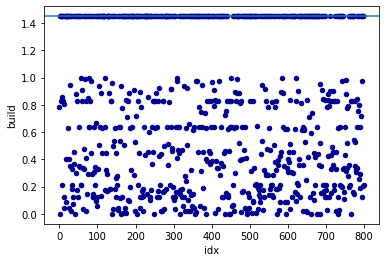

thresh hold mean: 0.4238916738696016


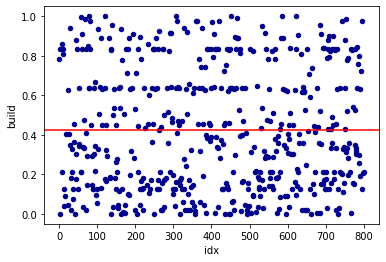

In [12]:
# all build optimize threshold 
# def _opt(x):
#     return -jaccard_score(gts[:, 0, 0].flatten(), predictions[:, 0 ,0].flatten() >= x, average='micro') 

# result = minimize(_opt, x0=np.array([0.45]), method='Powell', tol=1e-4)
# best_th = result['x'].item()
# print(f'optimize build threshold: {best_th:.5f}')

df_thresh.plot.scatter(x='idx', y='build', c='DarkBlue')
mean_th = df_thresh[f'road_c{c}'].values.mean()
print(f'threshold mean: {mean_th}')
plt.axhline(y=mean_th, xmin=0, xmax=len(df_thresh))
plt.savefig(f'{cfg.outdir}{cfg.group}/build_threshold_all_fold{fold}.png')
plt.show();

# 適切な閾値のみ
bet_th = df_thresh[df_thresh['build'] < 1.0]
mean_th = bet_th['build'].values.mean()
print(f'thresh hold mean: {mean_th}')

bet_th.plot.scatter(x='idx', y='build', c='DarkBlue')
plt.axhline(y=mean_th, xmin=0, xmax=len(bet_th), color='r')
plt.savefig(f'{cfg.outdir}{cfg.group}/build_threshold_better_fold{fold}.png')
plt.show();

threshold mean: 0.4293935399114068


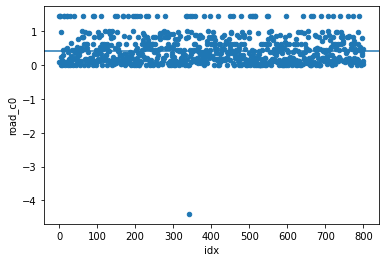

threshold mean: 0.3541477553204247


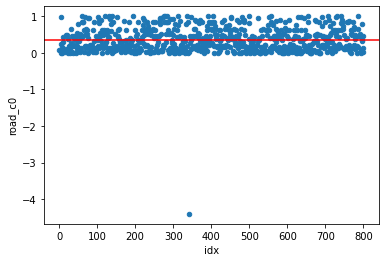

threshold mean: 1.4499999999999995


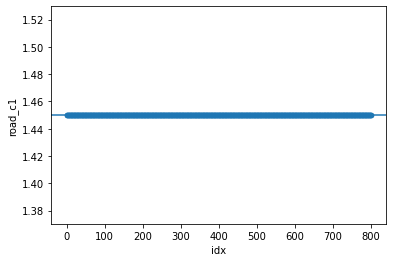

threshold mean: nan


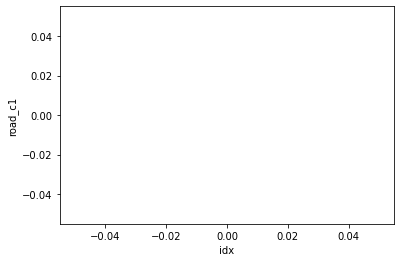

threshold mean: 0.73919730273967


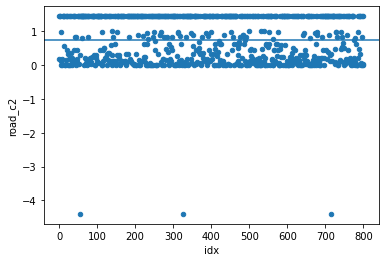

threshold mean: 0.24883341665501196


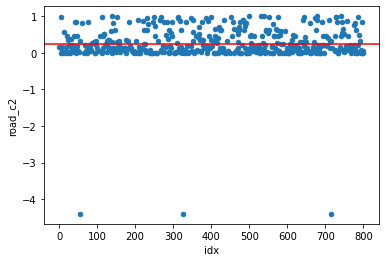

threshold mean: 0.9360161873864203


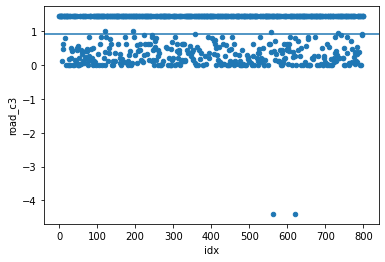

threshold mean: 0.2737113317043512


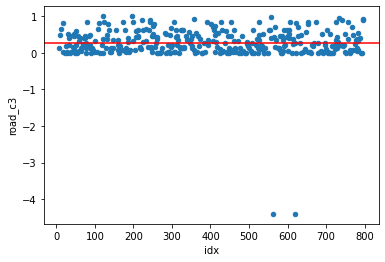

threshold mean: 1.1923487268302508


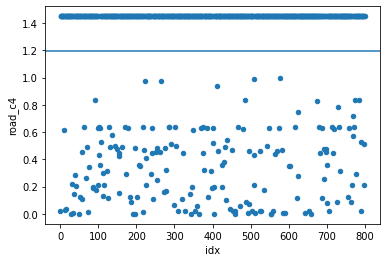

threshold mean: 0.3463707496846584


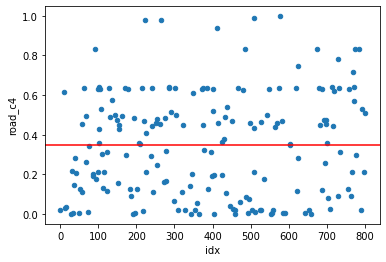

threshold mean: 1.3450557836872579


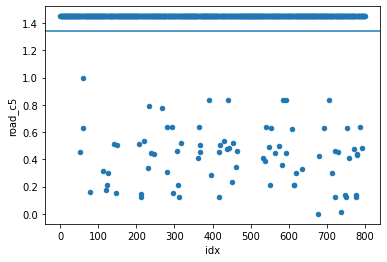

threshold mean: 0.4248741796767547


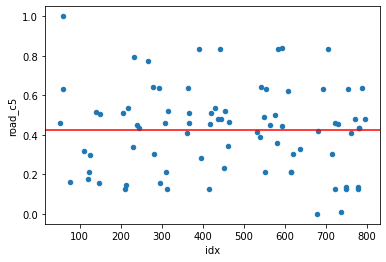

threshold mean: 1.4499999999999995


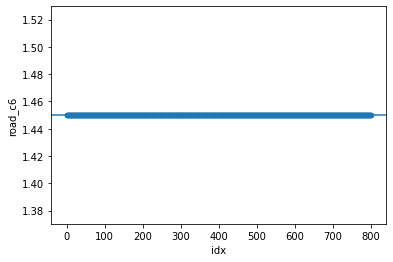

threshold mean: nan


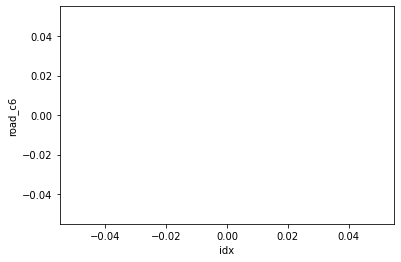

threshold mean: 1.4499999999999995


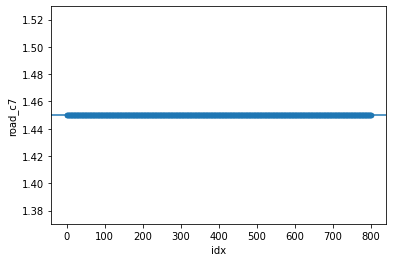

threshold mean: nan


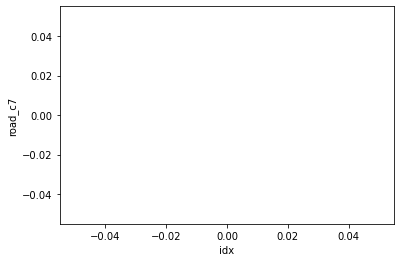

In [13]:
# all road optimize threshold
for c in range(8):    
    df_thresh.plot.scatter(x='idx', y=f'road_c{c}')
    mean_th = df_thresh[f'road_c{c}'].values.mean()
    print(f'threshold mean: {mean_th}')
    plt.axhline(y=mean_th, xmin=0, xmax=len(df_thresh))
    plt.savefig(f'{cfg.outdir}{cfg.group}/road_channel-{c}_threshold_all_fold{fold}.png')
    plt.show();

    # 適切な閾値のみ
    bet_th = df_thresh[df_thresh[f'road_c{c}'] < 1.0]
    mean_th = bet_th[f'road_c{c}'].values.mean()
    print(f'threshold mean: {mean_th}')

    bet_th.plot.scatter(x='idx', y=f'road_c{c}')
    plt.axhline(y=mean_th, xmin=0, xmax=len(bet_th), color='r')
    plt.savefig(f'{cfg.outdir}{cfg.group}/road_channel-{c}_threshold_better_fold{fold}.png')
    plt.show();

## Test

In [24]:
print(f'#'*60)
print(f'### Fold: {fold} HANSFOLD {HANSFOLD}')
print(f'### Start Inference')

ds_val = SpaceNnet8Dataset(fold=None, phase='test')
dl_val = DataLoader(ds_val, **cfg.val_loader)

for i, (images, _) in enumerate(dl_val):
    current_image_filename = ds_val.get_image_filename(i)
    print("evaluating: ", f'{i}/{len(ds_val)}', os.path.basename(current_image_filename))

    images = images[:, :cfg.model.in_channels, :, :]
    
    outputs = torch.zeros((1, 9, images.shape[-2], images.shape[-1]), dtype=torch.float32).to(device)
        
    for fold in range(cfg.folds):
        
        # fold setting
        dirpath = f'{cfg.outdir}{cfg.group}/{cfg.runname}_fold-{fold}/'
        # filename = f"best_fold-{fold}"
        filename = f"last"
        PATH_BEST_MODEL = f'{dirpath}{filename}.ckpt'

        save_preds_dir = f'{dirpath}test_fnd/'
        save_fig_dir = f'{dirpath}test_png/'
        os.makedirs(save_preds_dir, exist_ok=True)
        os.makedirs(save_fig_dir, exist_ok=True)
        
        # model
        model = SpaceNet8Model.load_from_checkpoint(PATH_BEST_MODEL, cfg=cfg)
        model.eval()
        if cfg.debug:
            device = torch.device('cpu')
        model = model.to(device)
        
        # TTA
        model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
    
        # cuda
        images = images.to(device)
        images = images.float()
        
        # inference
        with torch.no_grad():
            
            # outputs
            outputs += model(images)  
            
        if HANSFOLD:
            break
    
    # plt.figure(figsize=(8 , 6), dpi=70)
    # plt.title(f'fold sum')
    # plt.imshow(torch.sigmoid(outputs).cpu().numpy()[0, 0])
    # plt.colorbar()
    # plt.show();
    
    
    # mean average and logits
    if HANSFOLD:
        outputs = torch.sigmoid(outputs)
    else:
        outputs = torch.sigmoid(outputs / cfg.folds) 
    
    outputs = outputs.cpu().numpy()
    images = images.cpu().numpy()
    
    # assert np.count_nonzero(np.isnan(outputs)) == 0, f''
    
        
    # allocate
    preimg, postimg = images[0, :3, :, :], images[0, 3:, :, :]
    pred_build, pred_speed = \
        outputs[0, 0, :, :], outputs[0, 1:9, :, :]
        
    _pre_img = tifffile.imread(current_image_filename)
    _, _w, _h = _pre_img.shape
    
    predictions = np.zeros(
        (2, 8, _w, _h)
        ,)
    gts = np.zeros(
        (2, 8,  _w, _h)
        ,)
    # predictions = np.zeros(
    #     (2, 8, cfg.preprocess.input_size, cfg.preprocess.input_size)
    #     ,)
    # gts = np.zeros(
    #     (2, 8,  cfg.preprocess.input_size, cfg.preprocess.input_size)
    #     ,)
    
    # plt.figure(figsize=(8 , 6), dpi=70)
    # plt.title('threshold preocessed')
    # plt.imshow(pred_build)
    # plt.colorbar()
    # plt.show();

    _pred_build = cv2.resize(pred_build[..., np.newaxis].astype(np.float32), dsize=(_h, _w), interpolation=cv2.INTER_NEAREST)
    _pred_speed = cv2.resize(pred_speed.astype(np.float32).transpose(1, 2, 0), dsize=(_h, _w), interpolation=cv2.INTER_NEAREST).transpose(2, 0 , 1)
    
    # mask
    mask = 1. - (np.mean(_pre_img, 0) == np.zeros(_pre_img.shape[1:])).astype(np.float32)
    _pred_build = _pred_build * mask
    _pred_speed = _pred_speed * np.stack([mask]*8)
    
    # variavle threshold
    for vt_w in range(4):  
    
        # casting
        pred_build = np.where(_pred_build > cfg.model.threshold - (0.05 * vt_w), 1, 0)
        pred_speed = np.where(_pred_speed > cfg.model.threshold - (0.05 * vt_w) - 0.05, 1, 0)
        
        if np.count_nonzero(pred_speed) > 0:
            # 全面推論抑制
            if np.count_nonzero(pred_speed) > pred_speed.size * 0.75 or np.count_nonzero(pred_build) > pred_build.size * 0.75:
                pred_speed = np.zeros(pred_speed.shape, dtype=np.uint8)
                pred_build = np.zeros(pred_build.shape, dtype=np.uint8)
                break
            else:
                # 最適閾値
                break 
    
    predictions[0,0] = pred_build
    predictions[1,:] = pred_speed
    
    # plt.figure(figsize=(8 , 6), dpi=70)
    # plt.title('last preocessed')
    # plt.imshow(pred_build)
    # plt.colorbar()
    # plt.show();

    
    ### save prediction
    if save_preds_dir is not None:
        road_pred_arr = (pred_speed * 255).astype(np.uint8) # to be compatible with the SN5 eval and road speed prediction, need to mult by 255
        ds = gdal.Open(current_image_filename)
        geotran = ds.GetGeoTransform()
        xmin, xres, rowrot, ymax, colrot, yres = geotran
        raster_srs = osr.SpatialReference()
        raster_srs.ImportFromWkt(ds.GetProjectionRef())
        ds = None
        output_tif = os.path.join(save_preds_dir, os.path.basename(current_image_filename.replace(".tif","_roadspeedpred.tif")))
        nchannels, nrows, ncols = road_pred_arr.shape
        write_geotiff(output_tif, ncols, nrows,
                    xmin, xres, ymax, yres,
                    raster_srs, road_pred_arr)
                    
        building_pred_arr = np.array([(pred_build * 255).astype(np.uint8)])
        output_tif = os.path.join(save_preds_dir, os.path.basename(current_image_filename.replace(".tif","_buildingpred.tif")))
        nchannels, nrows, ncols = road_pred_arr.shape
        write_geotiff(output_tif, ncols, nrows,
                    xmin, xres, ymax, yres,
                    raster_srs, building_pred_arr)
    

    if save_fig_dir is not None:
        #if save_preds_dir is not None: # for some reason, seg fault when doing both of these. maybe file saving or something is interfering. so sleep for a little
        #    time.sleep(2) 
        save_figure_filename = os.path.join(save_fig_dir, os.path.basename(current_image_filename)[:-4]+"_pred.png")
        make_prediction_png_roads_buildings(preimg, gts, predictions,  save_figure_filename)

    
    torch.cuda.empty_cache()
    gc.collect()
    
    # early exit
    if cfg.debug and i > 2:
        break
    # break

############################################################
### Fold: 0 HANSFOLD False
### Start Inference
loaded 488 image filepaths
evaluating:  0/488 104001006504F400_0_35_12.tif
evaluating:  1/488 104001006504F400_0_20_36.tif
evaluating:  2/488 104001006504F400_0_20_36.tif
evaluating:  3/488 104001006504F400_0_13_26.tif
evaluating:  4/488 104001006504F400_0_13_22.tif
evaluating:  5/488 104001006504F400_0_17_17.tif
evaluating:  6/488 104001006504F400_0_31_23.tif
evaluating:  7/488 104001006504F400_0_3_36.tif
evaluating:  8/488 104001006504F400_0_14_33.tif
evaluating:  9/488 104001006504F400_0_0_16.tif
evaluating:  10/488 104001006504F400_0_19_16.tif
evaluating:  11/488 104001006504F400_0_17_13.tif
evaluating:  12/488 104001006504F400_0_3_19.tif
evaluating:  13/488 104001006504F400_0_10_21.tif
evaluating:  14/488 104001006504F400_0_38_10.tif
evaluating:  15/488 104001006504F400_0_23_31.tif
evaluating:  16/488 104001006504F400_0_23_31.tif
evaluating:  17/488 104001006504F400_0_36_15.